In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import Sequence
from sklearn.cluster import KMeans
import tensorflow as tf
np.set_printoptions(suppress=True)

In [3]:
pd.read_csv(os.path.join('../data/mn40','metadata_modelnet40.csv'))

,object_id,class,split,object_path
0,airplane_0627,airplane,test,airplane/test/airplane_0627.off
1,airplane_0628,airplane,test,airplane/test/airplane_0628.off
2,airplane_0629,airplane,test,airplane/test/airplane_0629.off
3,airplane_0630,airplane,test,airplane/test/airplane_0630.off
4,airplane_0631,airplane,test,airplane/test/airplane_0631.off
...,...,...,...,...
12306,xbox_0099,xbox,train,xbox/train/xbox_0099.off
12307,xbox_0100,xbox,train,xbox/train/xbox_0100.off
12308,xbox_0101,xbox,train,xbox/train/xbox_0101.off
12309,xbox_0102,xbox,train,xbox/train/xbox_0102.off


In [86]:
class MN40Loader(Sequence):
    def __init__(self, data_root, split, N=2096, batch_size=32, datamode='triangles'):
        self.data_root = data_root
        self.batch_size = batch_size
        self.N = N
        
        metadata = pd.read_csv(os.path.join(self.data_root, 'metadata_modelnet40.csv'))
        self.metadata = metadata.loc[metadata.split==split].sample(frac=1)
        
        #self.metadata = self.metadata[self.metadata['class'].isin(['xbox', 'airplane'])]
        self.labels = dict([(idx, label) for label, idx in enumerate(sorted(self.metadata['class'].unique()))])
        
        self.datamode = datamode
        
    def read_off(self, file):
        off_header = file.readline().strip()
        if 'OFF' == off_header:
            n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
        else:
            n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
        verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
        faces = [[int(idx) for idx in file.readline().strip().split(' ')[1:]] for _ in range(n_faces)]
        return tf.constant(verts), tf.ragged.constant(faces)

    def load_file_(self, obj_key):
        with open(os.path.join(self.data_root, 'ModelNet40', obj_key), 'r') as f:
            return self.read_off(f)
        
    def __len__(self):
        return np.ceil(len(self.metadata)/self.batch_size).astype(int)
        
        
    def __getitem__(self, idx):
        batch_meta = self.metadata.iloc[idx*self.batch_size : (idx+1)*self.batch_size]
        
        ys = batch_meta['class'].apply(lambda z: mn.labels[z]).values
        
        if self.datamode=='points':
            X = np.zeros((len(batch_meta), self.N, 3))
            mask = np.zeros((len(batch_meta), self.N), dtype=np.int32)

            vs = []

            for i, path in enumerate(batch_meta.object_path):
                verts, _ = self.load_file_(path)

                verts = np.unique(verts, axis=0)

                if len(verts) > self.N:
                    perm = np.random.choice(len(verts), replace=False, size=self.N)
                    verts = verts[perm]

                mask[i, :len(verts)] = np.ones(len(verts))

                X[i, :len(verts)] = verts 


            return [X, mask], ys
        
        elif self.datamode =='triangles':
            vertl, facel = [], []
            
            for i, path in enumerate(batch_meta.object_path):
                verts, faces = self.load_file_(path)
                
                vertl.append(verts), facel.append(faces)
                
            vertrag = tf.ragged.stack(vertl)
            facerag = tf.ragged.stack(facel)
            return tf.gather(vertrag, facerag, batch_dims=1).to_tensor(), ys

In [87]:
mn = MN40Loader('../data/mn40', 'train', N=10000)
mnt = MN40Loader('../data/mn40', 'test', N=10000)

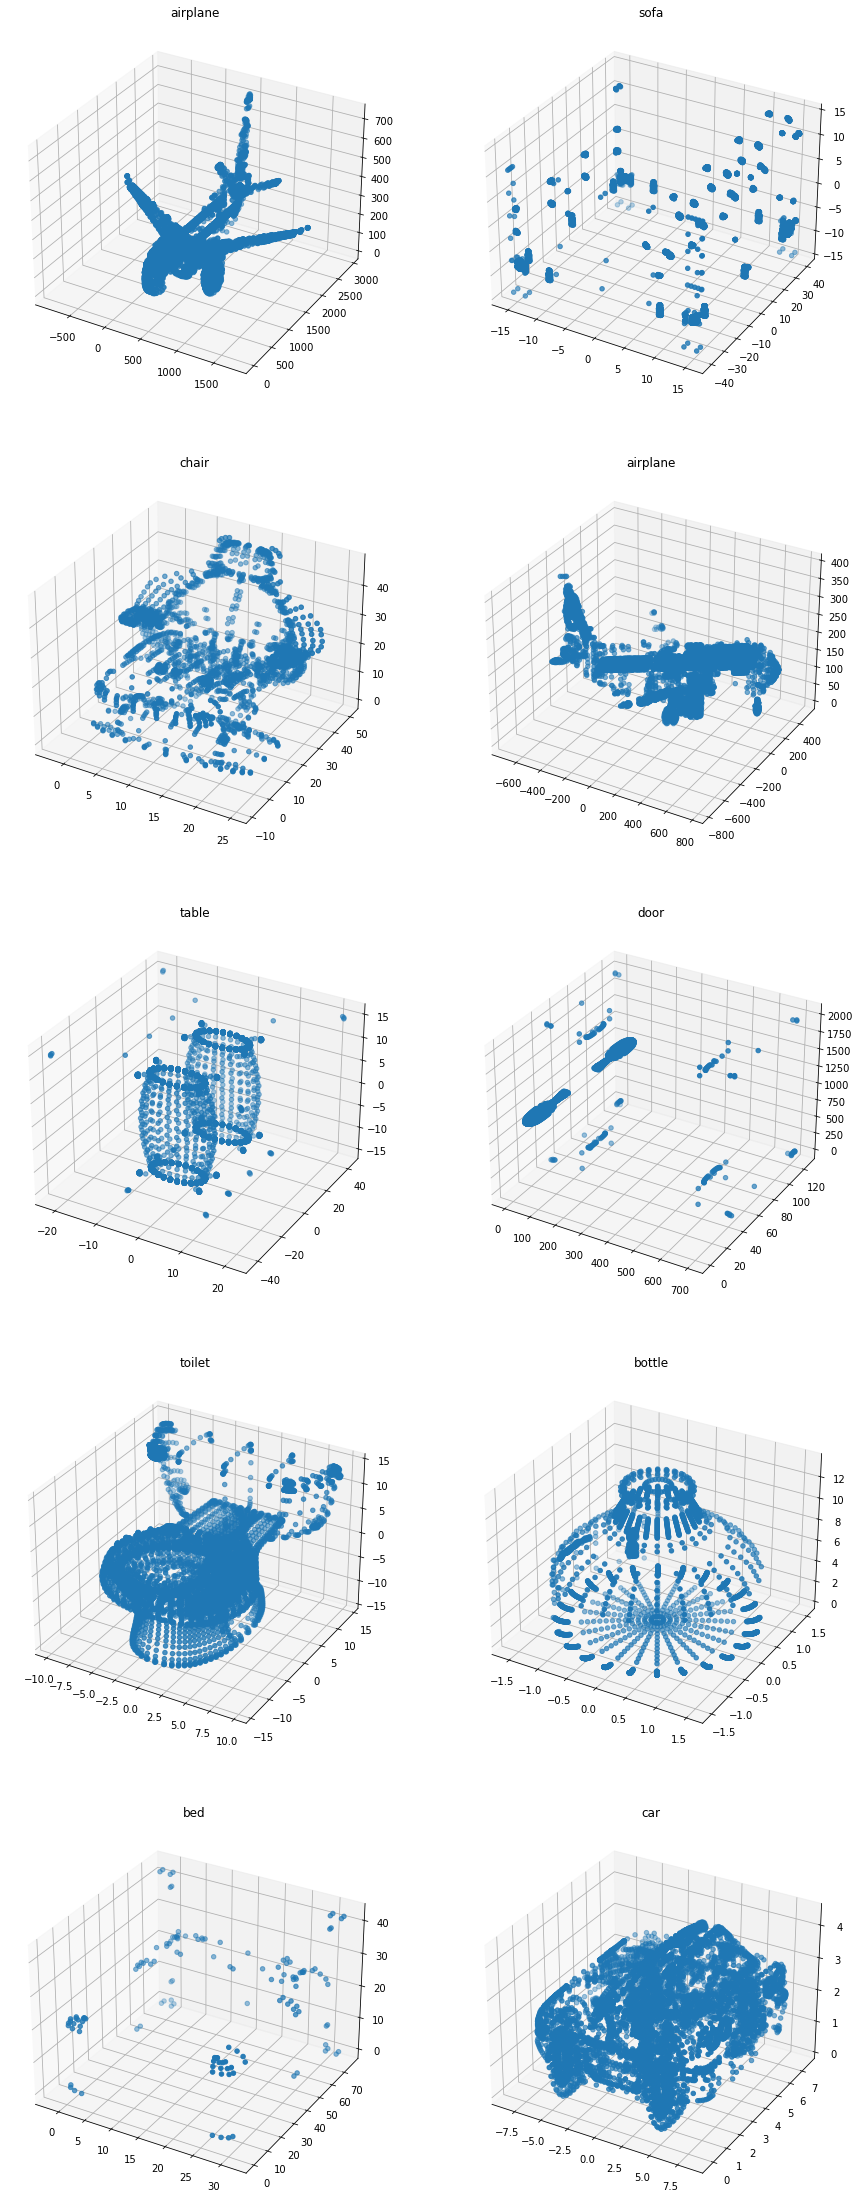

In [88]:
mn.datamode='points'
(points, mask),y = mn[0]

fig = plt.figure()
fig.set_size_inches(15,40)
ax = []
for i in range(10):
    ax = fig.add_subplot(5,2,i+1, projection='3d')
    ax.set_title(next(k for (k,v) in mn.labels.items() if v == y[i]))
    ax.scatter(*points[i, :sum(mask[i])].T)
mn.datamode='triangles'

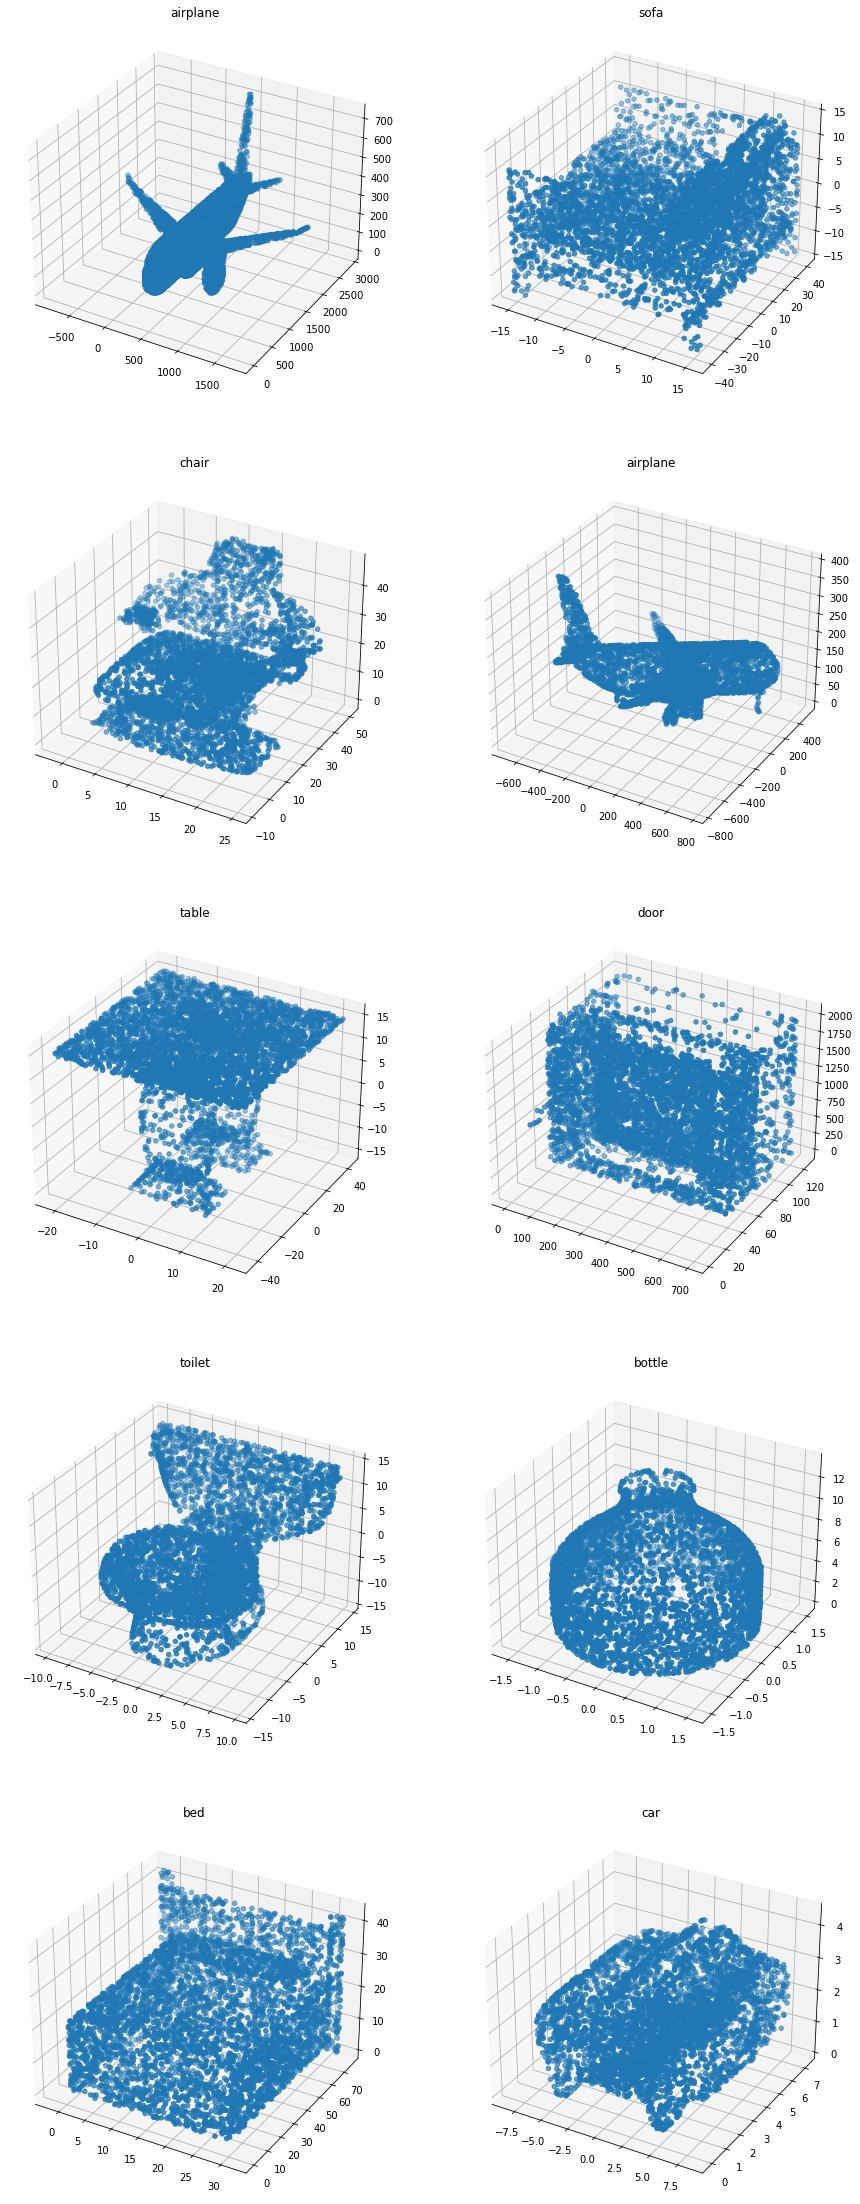

In [90]:
triangles, y = mn[0]

resampler = TriangleReSampler(5000)

fig = plt.figure()
fig.set_size_inches(15,40)
ax = []
xx,mm = resampler(triangles)
for i in range(10):
    
    ax = fig.add_subplot(5,2,i+1, projection='3d')
    ax.set_title(next(k for (k,v) in mn.labels.items() if v == y[i]))
    ax.scatter(*xx[i].numpy().T)

In [91]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Concatenate, Layer, Dense, TimeDistributed, MultiHeadAttention, GlobalMaxPooling1D, LSTM
import tensorflow as tf
import tensorflow_probability as tfp

In [92]:
class TriangleReSampler(Layer):
    def __init__(self, N, **kwargs):
        super(TriangleReSampler, self).__init__(**kwargs)
        self.N = N
        
    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        return (batch_size, self.N, input_shape[-1])
    
    def call(self, triangles):
        
        face_count = tf.shape(triangles)[1]
        batch_sz = tf.shape(triangles)[0]
        
        #print(face_count)
        
        u = triangles[:,:,0]
        v = triangles[:,:,1]
        w = triangles[:,:,2]
        
        #print(verts)
        
        uv = u-v
        wv = w-v
        
        #print(uv)
        
        areas = tf.norm(tf.linalg.cross(uv,wv), axis=-1)
        

        dist = tfp.distributions.FiniteDiscrete(tf.range(face_count), probs=areas)
            
        samp = tfp.distributions.Sample(dist)
        
        samples = tf.transpose(samp.sample((self.N,)))
        
        selected_uv = tf.gather(uv, samples, batch_dims=1)
        selected_wv = tf.gather(wv, samples, batch_dims=1)
        selected_v = tf.gather(v, samples, batch_dims=1)
        
        ur = tf.random.uniform((batch_sz, self.N, 1))
        wr = tf.random.uniform((batch_sz, self.N, 1))
        
        #print(ur)
        
        coefs = tf.cast(tf.math.ceil(ur+wr)-1, tf.bool)
        
        urf = tf.where(coefs, 1-ur, ur)
        wrf = tf.where(coefs, 1-wr, wr)
        
        sampled_points = selected_v+selected_uv*urf+selected_wv*wrf
        
        
        return sampled_points, tf.ones((batch_sz, self.N), dtype=tf.int32)

In [93]:
class PatchLayer(Layer):
    def __init__(self, patch_count, patch_size, patch_radius, **kwargs):
        super(PatchLayer, self).__init__(**kwargs)
        
        self.patch_size = patch_size
        self.patch_radius = patch_radius
        self.patch_count = patch_count
        
    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        return [(batch_size, self.patch_count, self.patch_size, 3),
                (batch_size, self.patch_count, self.patch_size),
                (batch_size, self.patch_count)
               ]
        
        
    def call(self, points, mask):
        batch_sz = tf.shape(points)[0]
        ## rescale
        mean, variance = tf.nn.moments(points, 1, keepdims=True)
        
        max_var = tf.math.reduce_max(variance, axis=2, keepdims=True)+1e-7
        
        new_points = (points-mean)/tf.sqrt(max_var)
        
        
        # select points
        
        free_points = tf.cast(tf.identity(mask), dtype=tf.float32)
        
        outcomes = tf.range(tf.shape(free_points)[1])
        distances = None
        
        
        ret_points = tf.TensorArray(tf.float32, size=self.patch_count)
        #ret_centers = tf.TensorArray(tf.float32, size=self.patch_count)
        ret_mask = tf.TensorArray(tf.int32, size=self.patch_count)
        ret_patch_mask = tf.TensorArray(tf.int32, size=self.patch_count)
        
        
        
        for i in tf.range(self.patch_count): 
            dist = tfp.distributions.FiniteDiscrete(outcomes, probs=free_points)
            
            samp = tfp.distributions.Sample(dist)
            
            point_idx = tf.transpose(samp.sample(sample_shape=(1,)))
            
            principal_points = tf.gather(new_points, point_idx, axis=1, batch_dims=1)
            
            displacements = principal_points - new_points
            
            distances = tf.norm(displacements, axis = -1)
            
            close_enough_points = tf.less(distances, self.patch_radius) # which points are close enough
            
            valid_points = tf.math.logical_and(close_enough_points, tf.cast(free_points, tf.bool))
            
            d_idx = tf.argsort(distances) # which are the closest
            
            point_sel = tf.gather(valid_points, d_idx, batch_dims=1) # 
            
            taken_points = tf.argsort(tf.cast(point_sel, tf.float32), direction='DESCENDING')[:, :self.patch_size] # take the patch_size closest points
            
            point_mask = tf.cast(tf.gather(point_sel, taken_points, batch_dims=1), tf.int32)
            point_indices = tf.gather(d_idx, taken_points, batch_dims = 1)
            
            batch_points = tf.gather(new_points, point_indices, batch_dims = 1)
            
            #bmean, _ = tf.nn.moments(batch_points, 1, keepdims=True)
            
            #batch_points = batch_points - bmean

        
            used = tf.einsum("bce,bc->be",
                           tf.one_hot(point_indices, tf.shape(points)[1]), 
                           tf.cast(point_mask, tf.float32))
            
            was_updated = tf.cast(tf.greater(tf.reduce_sum(used, -1), 0.5), tf.int32)
            
            free_points = free_points-used
        
            
            
            ret_points = ret_points.write(i, batch_points)
            #ret_centers = ret_centers.write(i, tf.squeeze(bmean))
            ret_mask = ret_mask.write(i, point_mask)
            ret_patch_mask = ret_patch_mask.write(i, was_updated)
        
        

        return  tf.transpose(ret_points.stack(), perm=[1,0,2,3]), \
                tf.transpose(ret_mask.stack(), perm=[1,0,2]), \
                tf.transpose(ret_patch_mask.stack(), perm=[1,0])

In [94]:
class CLSPrepadLayer(Layer):
    def __init__(self, patch_size, d, **kwargs):
        super(CLSPrepadLayer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.d = d
        
    def build(self, in_shape):
        self.class_patch_emb = self.add_weight("cls_pat_emb", shape=(1, 1, self.patch_size, 3))
        #self.class_cent_emb = self.add_weight("cls_cnt_emb", shape=(1, 3))
        
    def call(self, patches, point_mask, patch_mask):
        batch_size = tf.shape(patches)[0]

        class_emb = tf.broadcast_to(
            self.class_patch_emb, [batch_size, 1, self.patch_size, 3]
        )
        """
        class_cent_emb = tf.broadcast_to(
            self.class_cent_emb, [batch_size, 1, 3]
        )
        """
        

        from_mask = tf.concat([tf.ones((batch_size, 1), dtype=tf.int32), patch_mask], axis=1)
        to_mask = tf.concat([tf.zeros((batch_size, 1), dtype=tf.int32), patch_mask], axis=1)
        
        cls_to_cls_pre = tf.concat([tf.ones((batch_size, 1), dtype=tf.int32), tf.zeros_like(patch_mask)], axis=1)
        
        cross_mask = tf.einsum('bi,bj->bij', from_mask, to_mask)
        cls_to_cls_mask = tf.einsum('bi,bj->bij', cls_to_cls_pre, cls_to_cls_pre)
        
        
        cls_point_mask = tf.ones((batch_size, 1, self.patch_size), dtype=tf.int32)
        
        return tf.concat([class_emb, patches], axis=1), \
                tf.concat([cls_point_mask, point_mask], axis=1), \
                cross_mask + cls_to_cls_mask

In [95]:
class LDDMMSelfAttentionLayer(Layer):
    def __init__(self, emb_dim, **kwargs):
        super(LDDMMSelfAttentionLayer, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        
        self.Qs = TimeDistributed(Dense(emb_dim))
        self.Ks = TimeDistributed(Dense(emb_dim))
        self.Vs = TimeDistributed(Dense(emb_dim))
        
        self.center_attention = MultiHeadAttention(1, emb_dim)
        
    def call(self, patches, point_mask, attention_mask):

        # calculate shape scores
        
        return patches
        

In [96]:
class PoolingSelfAttentionLayer(Layer):
    def __init__(self, emb_dim, **kwargs):
        super(PoolingSelfAttentionLayer, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        
        self.att1 = MultiHeadAttention(1, self.emb_dim, value_dim=128)
        
    def call(self, patches, point_mask, attention_mask):
        float_mask = tf.cast(point_mask, tf.float32)
        ## zero out with mask
        masked = patches*float_mask[:,:,:,tf.newaxis]
        sums = tf.reduce_sum(patches, axis=2)
        weights = (tf.reduce_sum(float_mask, axis=-1, keepdims=True)+1e-7)
        
        means = sums/weights
        
        
        return self.att1(means, means, attention_mask=attention_mask)

In [97]:
class LSTMSelfAttentionLayer(Layer):
    def __init__(self, emb_dim, **kwargs):
        super(LSTMSelfAttentionLayer, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        
        self.lstm = TimeDistributed(LSTM(emb_dim, recurrent_activation='tanh'))
        
        self.att = MultiHeadAttention(4, emb_dim)
        
    def call(self, patches, point_mask, att_mask, training):
        
        reprs = self.lstm(patches, mask=tf.cast(point_mask, tf.bool), training=training)
        
        return self.att(reprs, reprs, attention_mask=att_mask)

In [98]:
class ManifoldTransformer(Model):
    def __init__(self, N, patch_count, patch_size, patch_radius, attention_dim):
        super(ManifoldTransformer, self).__init__()
        self.patch_count = patch_count
        self.N = N
        
        self.resampler = TriangleReSampler(N)
        
        self.patch_layer = PatchLayer(patch_count-1, patch_size, patch_radius)
        self.seqproc = CLSPrepadLayer(patch_size, 3)
        
        self.patch_trans = TimeDistributed(Dense(256, activation='tanh'))
        
        self.attention_layer1 = LSTMSelfAttentionLayer(128)
        self.attention_layer2 = MultiHeadAttention(1, 128)
        
        self.dense1 = Dense(128, activation = 'relu')
        self.dense2 = Dense(40, activation='softmax')

    def summary(self):
        x = Input(shape=(None, 3), ragged=True, name='verts')
        faces = Input(shape=(None,3), dtype=tf.int32, ragged=False, name='faces')
        model = Model(inputs=[x, faces], outputs=self.call([x, faces], False))
        return model.summary()
    
    
    def call(self, triangles, training):
        seq, mask = self.resampler(triangles)
    
        patches, point_mask, patch_mask = self.patch_layer(seq, mask)
    
        patches, point_mask, attention_mask = self.seqproc(patches, point_mask, patch_mask)
        
        patches = self.patch_trans(patches)
        
        att1 = self.attention_layer1(patches, point_mask, attention_mask, training)
        
        att2 = self.attention_layer2(att1, att1, attention_mask= attention_mask)
        
        cls = att2[:, 0]
        
        x = self.dense1(cls)
        
        pred = self.dense2(x)
    
        return pred

In [99]:
def create_model(N, patch_count, patch_size, patch_radius, attention_dim):
    model = ManifoldTransformer(N, patch_count, patch_size, patch_radius, attention_dim)
    
    #model.build(input_shape=[(None, None, 3), (None, None, 3)])
    
    model.compile('adam', 'sparse_categorical_crossentropy', metrics='accuracy')
    
    return model

In [100]:
model = create_model(2048, 64, 32, 0.3, 32)

In [101]:
from sklearn.utils.class_weight import compute_class_weight

In [102]:
cws = dict(enumerate(compute_class_weight('balanced', y=[mn.labels[x] for x in mn.metadata['class']], classes=range(40))))

In [103]:
model.fit(mn, validation_data=mnt, epochs=10, workers=32, class_weight=cws)

Epoch 1/10
 25/308 [=>............................] - ETA: 32:16 - loss: 3.7261 - accuracy: 0.0213 - ETA: 17:03 - loss: 3.7139 - accuracy:  - ETA: 12:03 - loss: 3.7078 - accuracy: 0.02 - ETA: 37:08 - loss: 3.7744 - accuracy: - ETA: 26:58 - loss: 3.7540 - accuracy: 0

KeyboardInterrupt: 

In [18]:
from tqdm import tqdm

In [ ]:
means = ls[0]*ls[1][:,:,:,tf.newaxis]

In [ ]:
means.shape

In [ ]:
means.sum(axis=2)/(ls[1].sum(axis=-1, keepdims=True)+1e-7)

In [ ]:
fig = plt.figure()
fig.set_size_inches(15,40)
ax = fig.add_subplot(1,1,1, projection='3d')
for (pts, msk) in zip(ls[0][0], ls[1][1]):
    ax.scatter(*pts[:msk.sum()].T)

In [ ]:
from tqdm import tqdm

In [ ]:
for v,_ in tqdm(mn, total=len(mn)):
    for ll in v:
        l.append(ll.shape[0])

In [ ]:
len(list(filter(lambda z: z < 25000, l)))/len(l)

In [ ]:
mn.metadata['class'].unique()

In [ ]:
mn.metadata